In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from datetime import datetime,timedelta
import json
from scipy.stats import pearsonr

In [7]:
df = pd.read_csv("data/merged_election_pages.csv", parse_dates=['timestamp'],
                                      index_col=['timestamp'],)
df.head()

,wikicode,hourly_views
timestamp,,
2009-05-21,cs.wikipedia,4
2009-05-21,da.wikipedia,1
2009-05-21,de.wikipedia,47
2009-05-21,el.wikipedia,1
2009-05-21,fi.wikipedia,1


In [5]:
f = open('./data/eu_elections.json')
election_data = json.load(f)

In [10]:
df = df.groupby(['wikicode', pd.Grouper(freq='D')]).sum().reset_index( level = ['wikicode'])
df.rename(columns = {'hourly_views':'views'}, inplace = True)

scaler = MinMaxScaler()
df['views_norm'] = df.groupby([df.index.year, 'wikicode'])['views'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [9]:
pivot_df = df.pivot_table(index='timestamp', columns='wikicode', values='views_norm')
df_2014 = pivot_df[pivot_df.index.year == 2014]
df_2019 = pivot_df[pivot_df.index.year == 2019]

def plot_data(df, year):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Normalized Daily Page Views')
    ax1.margins(y=0)
    left, bottom, width, height = [0.2, 0.6, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax1.plot(df)
    ax2.plot(df)
    ax2.set_yscale("log", base=10)
    ax2.xaxis.set_ticklabels([])
    ax2.tick_params(labeltop=True, labelright=True)
    fig.suptitle(f'Normalized Wikipedia Election Page Views two weeks before and after the {year} European Parliament Elections')

    # Add color legend
    ax1.legend(df.columns)

    plt.show()


plot_data(df_2014, 2014)
plot_data(df_2019, 2019)

KeyError: 'views_norm'

In [ ]:
# Build up phase volume: sum of page views 7 days before electio date
country_lst = []
turnout_lst = []
page_views_lst = []
for country in election_data.keys():
    res = (election_data[country]["2019"]["turnout"] - election_data[country]["2014"]["turnout"])/election_data[country]["2014"]["turnout"]
    election_data[country]["relative_change_turnout"] = res
    turnout_lst.append(res)

for country in election_data.keys():
    sum_dct = {}
    for year in ["2014", "2019"]:
        election_date = datetime.strptime(election_data[country][year]["election_date"], "%Y-%m-%d")
        country_df = df[df["wikicode"] == election_data[country]["wikicode"]]

        start_date = election_date - timedelta(days=7)
        end_date = election_date
        
        sum = country_df[(country_df.index >= start_date) & (country_df.index <= end_date)]["views"].sum()
        
        sum_dct[year] = sum
    res = (sum_dct["2019"] - sum_dct["2014"])/sum_dct["2014"]
    election_data[country]["relative_change_page_views"] = res
    page_views_lst.append(res)
    country_lst.append(country)

In [ ]:
change_df = pd.DataFrame({"country": country_lst, "rel_change_turnout": turnout_lst, "rel_change_views": page_views_lst})
change_df.head()

,country,rel_change_turnout,rel_change_views
0,CZ,0.578022,7.982143
1,DK,0.173295,1.805461
2,DE,0.276091,0.206440
3,EL,-0.021344,0.044216
4,FI,0.043478,1.941707


In [ ]:
# exclude PL and ES
# change_df = change_df[change_df["country"] != "PL"]
# change_df = change_df[change_df["country"] != "CZ"]
# change_df = change_df[change_df["country"] != "ES"]

In [ ]:
correlation, p_value = pearsonr(change_df["rel_change_views"], change_df["rel_change_turnout"])
print("Correlation coefficient (r):", correlation)
print("P-value:", p_value)

Correlation coefficient (r): 0.24188152174577865
P-value: 0.42593234868390173


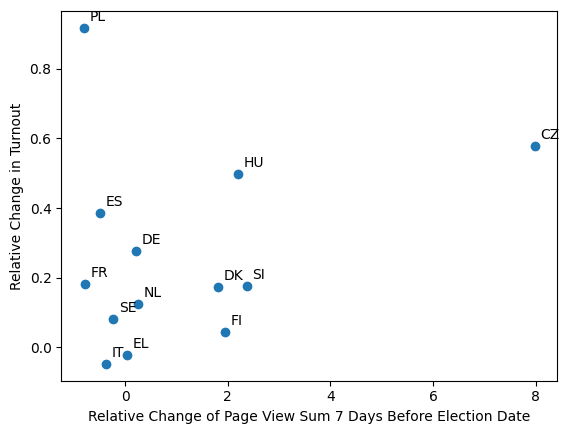

In [ ]:

plt.scatter(change_df["rel_change_views"], change_df["rel_change_turnout"])

for i in range(len(change_df)):
    x = change_df["rel_change_views"].iloc[i]
    y = change_df["rel_change_turnout"].iloc[i]
    country = change_df["country"].iloc[i]
    plt.annotate(country, xy=(x, y), xytext=(4, 5), textcoords="offset points")

# Create a line plot for the correlation line
# x_line = np.linspace(min(change_df["rel_change_views"]), max(change_df["rel_change_views"]), 100)
# y_line = correlation * x_line
# plt.plot(x_line, y_line, color='red', linestyle='--', label='Correlation line')

plt.xlabel("Relative Change of Page View Sum 7 Days Before Election Date")
plt.ylabel("Relative Change in Turnout")

plt.show()


In [ ]:
election_data["PL"]["relative_change_page_views"]

-0.8069193515645391

In [ ]:
election_data["CZ"]["relative_change_page_views"]

7.982142857142857

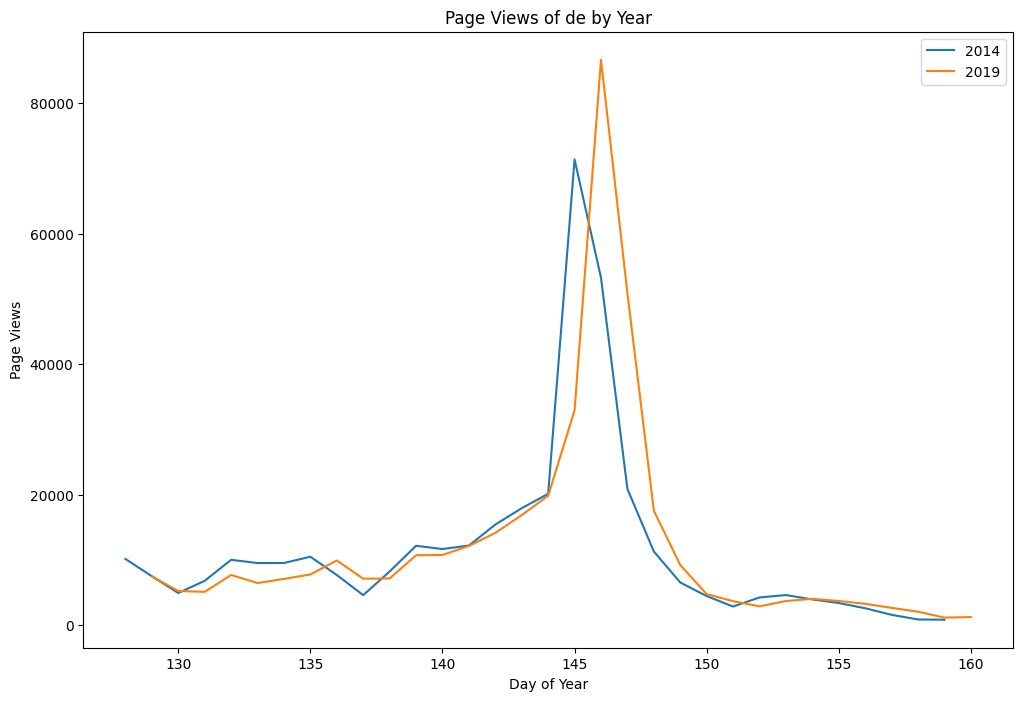

In [ ]:
import matplotlib.pyplot as plt
c = "de"
# Filter the DataFrame for Poland and Czech Republic
df_single = df[df['wikicode'] == f'{c}.wikipedia'].copy()

# Convert the date to day of year using .loc indexer
df_single.loc[:, 'day_of_year'] = df_single.index.dayofyear

# Group the DataFrame by year
grouped = df_single.groupby(df_single.index.year)

# Create the plot
plt.figure(figsize=(12, 8))

# Iterate over each group and plot
for year, group in grouped:
    plt.plot(group['day_of_year'], group['views'], label=str(year))

# Add labels and title
plt.xlabel('Day of Year')
plt.ylabel('Page Views')
plt.title(f'Page Views of {c} by Year')

# Add a legend
plt.legend()

# Show the plot
plt.show()
